In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, t, laplace
import seaborn as sns
import os, wget, shutil
from rich import print as pprint
import warnings
warnings.filterwarnings("ignore")
from math import erf, fabs, sqrt
from numba import njit, prange

# Background

Previously, we demonstrated how a naive release of aggregated statistics could be vulnerable to inference attacks. In particular, we showed that if the user’s pipeline consisted of nothing more than computing a sample mean, then an adversary could potentially reverse-engineer the output and learn information about specific individuals, specially with the presence of outliers. To mitigate this, we introduced a noise-injection method (Global Differential Privacy), which ensured that the released statistic, or result was less directly tied to any one data point while still retaining utility.

The initial demonstration used the mean as a baseline case, since it is both simple and widely used. But real-world analysis rarely stops at the mean. Analysts often rely on more complex statistics to draw meaningful conclusions.

# What's next?

In this next stage, we extend the evaluation of our method to different user pipelines:

- Mean
- Standard Deviation
- One Sample t-test

The one-sample t-test is a natural choice for evaluation because it allows us to study two key properties:

- **Type I Error**: How often a noisy test incorrectly rejects the null hypothesis when it is true.
- **Power Statistics**: How well the noisy test detects true effects of varying magnitudes.

# What to Expect

- A demonstration of how our GDP generalizes from the mean to more complex pipelines.
- An exploration of how adding noise affects statistical reliability, measured by type I error rates and power curves.



In [2]:
@njit
def std_UO(data):
    
    mean_ = np.mean(data)
    std_ = np.sqrt(np.sum((data - mean_) ** 2) / (len(data) - 1))
    
    return std_ 
    

@njit
def ttest_1samp_UO(a, popmean):
    
    n = len(a)
    df = n - 1
    mean_ = np.mean(a)
    std_ = np.sqrt(np.sum((a - mean_) ** 2) / (len(a) - 1))
    
    t = (mean_ - popmean) / (std_ / sqrt(n))
    p = 2 * (1 - 0.5 * (1 + erf(fabs(t) / sqrt(2))))
    
    return t, p

@njit
def dp_(clean_data, pipeline_output):
    n = clean_data.size
    loo_output = np.empty(n)
    
    for i in range(n):
        temp = np.empty(n - 1)
        idx = 0
        for j in range(n):
            if j != i:
                temp[idx] = clean_data[j]
                idx += 1
        loo_output[i] = np.mean(temp)

    scale = np.sqrt(np.sum((loo_output - np.mean(loo_output)) ** 2) / (len(loo_output) - 1))
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    
    noise = 0.0
    while True:
        noise = np.random.normal(0.0, 2 * scale)
        if abs(noise) >= sensitivity:
            break
    return pipeline_output + noise, sensitivity

@njit
def mean_UO(data):

    pipeline_output = np.mean(data)
    return pipeline_output

In [3]:
@njit(parallel=True)
def ttest_sim(null_true_mu=170, 
              std_dev=10, 
              alpha_=0.05,
              effect_sizes=np.array([0, 0.2, 0.5, 0.8, 1.0]),
              n_simulations=10000,
              sample_sizes=np.array([20, 40, 60, 80, 100])):    

    n_sizes = len(sample_sizes)
    n_effects = len(effect_sizes)
    type1_errors = np.zeros((n_simulations, n_sizes))
    powers = np.zeros((n_simulations, n_effects-1, n_sizes))
    
    for n in prange(n_simulations):
        for e in range(n_effects):
            effect = effect_sizes[e]
            true_mean = null_true_mu if effect == 0 else null_true_mu + effect * std_dev
            for s in range(n_sizes):
                size = sample_sizes[s]
                data = np.random.normal(true_mean, std_dev, size)
                output = mean_UO(data)
                noisy_output, _ = dp_(data, output)
                _, p = ttest_1samp_UO(data, null_true_mu)
                if p < alpha_:
                    if effect == 0:
                        type1_errors[n, s] += 1
                    else:
                        powers[n, e-1, s] += 1
    
    for n in range(n_simulations):
        for s in range(n_sizes):
            size = sample_sizes[s]
            if type1_errors[n, s] > 0:
                type1_errors[n, s] /= size
            for e in range(n_effects-1):
                if powers[n, e, s] > 0:
                    powers[n, e, s] /= size
    
    return type1_errors, powers, effect_sizes, sample_sizes

result = ttest_sim(n_simulations=10000)
type1_errors, powers, effect_sizes, sample_sizes = result

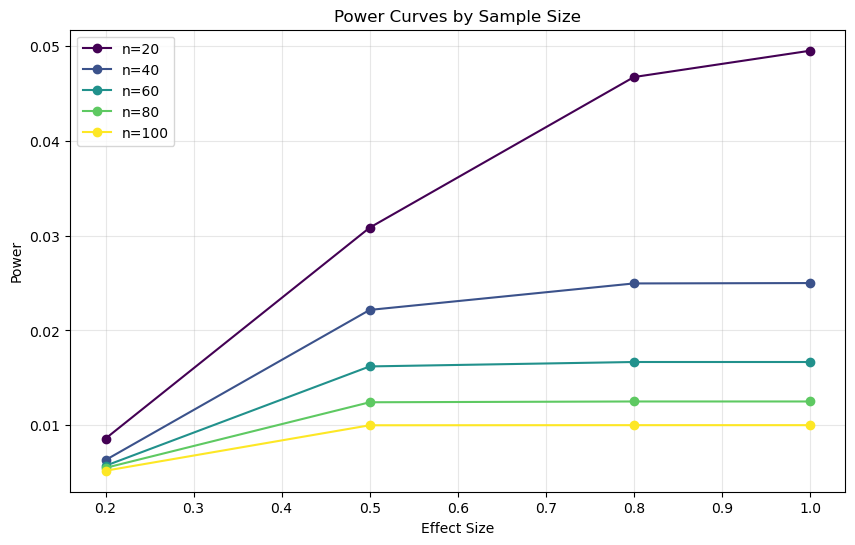

In [5]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))
for s, size in enumerate(sample_sizes):
    power_curve = []
    for e in range(powers.shape[1]):
        power_curve.append(np.mean(powers[:, e, s]))
    plt.plot(effect_sizes[1:], power_curve, 'o-', color=colors[s], label=f'n={size}', markersize=6)
plt.xlabel('Effect Size')
plt.ylabel('Power')
plt.title('Power Curves by Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [3]:
@njit(parallel=True)
def ttest_sim(null_true_mu=170, 
              std_dev=10, 
              alpha_=0.05,
              effect_sizes=np.array([0, 0.2, 0.5, 0.8, 1.0]),
              n_simulations=10,
              sample_sizes=np.array([20, 40, 60, 80, 100])):    

    n_sizes = len(sample_sizes)
    n_effects = len(effect_sizes)
    type1_errors = np.zeros((n_simulations, n_sizes)) 
    powers = np.zeros((n_simulations, n_effects-1, n_sizes))  
    
    for n in prange(n_simulations):
        for e in range(n_effects):
            effect = effect_sizes[e]
            true_mean = null_true_mu if effect == 0 else null_true_mu + effect * std_dev
            
            for s in range(n_sizes):
                size = sample_sizes[s]
                data = np.random.normal(true_mean, std_dev, size)
                rejections = 0
                for i in range(size):
                    loo_data = np.concatenate((data[:i], data[i+1:]))
                    output = mean_UO(loo_data)
                    noisy_output, _ = dp_(loo_data, output)
                    _, p = ttest_1samp_UO(loo_data, null_true_mu)
                    
                    if p < alpha_:
                        rejections += 1
                
                rejection_rate = rejections / size
                if effect == 0:
                    type1_errors[n, s] = rejection_rate
                else:
                    powers[n, e-1, s] = rejection_rate
    
    return {
        'type1_errors': type1_errors,
        'powers': powers,
        'effect_sizes': effect_sizes,
        'sample_sizes': sample_sizes
    }


ttest_sim(n_simulations=10)

TypeError: cannot convert native LiteralStrKey[Dict]({Literal[str](type1_errors): Array(float64, 2, 'C', False, aligned=True), Literal[str](powers): Array(float64, 3, 'C', False, aligned=True), Literal[str](effect_sizes): Array(float64, 1, 'C', False, aligned=True), Literal[str](sample_sizes): Array(int64, 1, 'C', False, aligned=True)}) to Python object

In [4]:
# sns.set(style="whitegrid")
# palette = sns.color_palette("Set1")

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_orig", hue="effect_size", palette=palette, marker="o", linewidth=2)
# sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_standard", hue="effect_size", palette=palette, marker="o", linewidth=2)
# sns.lineplot(data=df[df['effect_size'] > 0], x="sample_size", y="power_noised", hue="effect_size", palette=palette, marker="x", linestyle="--", linewidth=2, legend=False)
# plt.title("Power vs Sample Size")
# plt.ylabel("Power")
# plt.xlabel("Sample Size")
# plt.legend(title="Effect Size")
# plt.tight_layout()
# plt.show()

In [5]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_orig", hue="alpha", palette=palette, marker="o", linewidth=2)
# sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_standard", hue="alpha", palette=palette, marker="o", linewidth=2)
# sns.lineplot(data=df[df['effect_size'] == 0], x="sample_size", y="type_I_noised", hue="alpha", palette=palette, marker="x", linestyle="--", linewidth=2, legend=False)
# plt.title("Type I Error Rate vs Sample Size")
# plt.ylabel("Type I Error Rate")
# plt.xlabel("Sample Size")
# plt.legend(title="Alpha Level")
# plt.tight_layout()
# plt.show()



In [6]:
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x="sample_size", y="sensitivity", hue="effect_size", palette=palette, marker="o", linewidth=2)
# plt.title("Sensitivity vs Sample Size")
# plt.ylabel("Sensitivity")
# plt.xlabel("Sample Size")
# plt.legend(title="Effect Size")
# plt.tight_layout()
# plt.show()


In [7]:

# plt.figure(figsize=(14, 8))
# alpha_ = [0.01, 0.05, 0.1]
# for i, size in enumerate(sample_sizes):
#     plt.subplot(2, 3, i+1)
#     al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
#     al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
#     al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
#     plt.plot(al1['effect_size'], al1['power_standard'], 'o-', label='alpha 0.01')
#     plt.plot(al2['effect_size'], al2['power_standard'], 'o-', label='alpha 0.05')
#     plt.plot(al3['effect_size'], al3['power_standard'], 'o-', label='alpha 0.1')
       
#     plt.xlabel('Effect Size')
#     plt.ylabel('Power')
#     plt.title(f'Sample Size = {size}')
#     plt.ylim(0, 1.05)
#     plt.grid(True)
#     if i == 0:
#         plt.legend()

# plt.tight_layout()
# plt.suptitle(f'Power Comparison', y=1.02)
# plt.show()




In [8]:
# df = pd.DataFrame(results)

# plt.figure(figsize=(14, 8))
# alpha_ = [0.01, 0.05, 0.1]
# for i, size in enumerate(sample_sizes):
#     plt.subplot(2, 3, i+1)
#     al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
#     al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
#     al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
#     plt.plot(al1['effect_size'], al1['power_noised'], 'o-', label='alpha 0.01')
#     plt.plot(al2['effect_size'], al2['power_noised'], 'o-', label='alpha 0.05')
#     plt.plot(al3['effect_size'], al3['power_noised'], 'o-', label='alpha 0.1')
       
#     plt.xlabel('Effect Size')
#     plt.ylabel('Power')
#     plt.title(f'Sample Size = {size}')
#     plt.ylim(0, 1.05)
#     plt.grid(True)
#     if i == 0:
#         plt.legend()

# plt.tight_layout()
# plt.suptitle(f'Power Comparison noisy values', y=1.02)
# plt.show()




In [9]:

# plt.figure(figsize=(10, 6))
# plt.hist(p_n, bins=50, alpha=0.6, label='Null Hypothesis (True)', color='blue')
# plt.hist(p_a, bins=50, alpha=0.6, label='Alternative Hypothesis (True)', color='red')
# plt.axvline(alpha, color='black', linestyle='--', label=f'Significance Level (alpha = {alpha})')
# plt.title('Distribution of P-values Under Null and Alternative Hypotheses')
# plt.xlabel('P-value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [10]:
# def calc_sens(data):
#     loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
#     loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
#     mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
#     std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
#     return mean_sensitivity, std_sensitivity

# def add_noise(clean_data, pipeline_mean, pipeline_std):
    
#     mean_sens, std_sens = calc_sens(clean_data)
#     noisy_mean = pipeline_mean + np.random.laplace(loc=0, scale=mean_sens)
#     noisy_std = pipeline_std + np.random.laplace(loc=0, scale=std_sens)
#     noisy_std = max(noisy_std, 0.1)  
    
#     return noisy_mean, noisy_std, mean_sens, std_sens